# Bread Hypothetical A/B Test Analysis

### Table of Contents
1. Import and explore data
2. Data cleaning and feature engineering
3. What was the impact from implementing Intellicron?
4. Perform a hypothesis test to measure the A/B test results. What was the result of the hypothesis test? What is your confidence interval?
5. Was test and control group assignment done correctly? How can you tell? Is there anything you would do differently next time?
6. Should we implement Intellicron? What other data, if any, would you need to make this determination?

## 1. Import and explore data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(42)

prequals = pd.read_csv('prequals.csv')
intellicron_prequals = pd.read_csv('intellicron_prequals.csv')

print(f"There are {len(prequals)} records in prequals")
print(f"There are {len(intellicron_prequals)} records in intellicron_prequals")

There are 190976 records in prequals
There are 8609 records in intellicron_prequals


### Preview table data

In [2]:
prequals.head()

,Unnamed: 0,prequal_id,checkout_id,prequal_date,completed_prequal,approved
0,1,00081cb5-27bb-428a-bc53-076bacc7ad02,NaN,2019-06-22,1,0
1,2,00120f05-bf9d-40db-99d1-05a8cbd8aa0e,NaN,2019-04-16,0,0
2,3,00139f6d-0af4-49c5-b26f-f9c999a06bcb,6e01514b-6b6b-4510-8f6c-d994b871273c,2019-05-09,1,1
3,4,0019854e-e4c2-42df-be79-59cf1a13ac89,NaN,2019-01-17,0,0
4,5,0019cb64-a44c-4320-b149-9c0167c714e9,NaN,2019-04-16,1,1


In [3]:
intellicron_prequals.head()

,Unnamed: 0,prequal_id,assignment_date
0,1,00081cb5-27bb-428a-bc53-076bacc7ad02,2019-06-22
1,2,0136e545-347d-4a3b-b964-0a4561d32567,2019-06-22
2,3,0144b69a-f364-4746-8600-f6d7334d8f3f,2019-06-27
3,4,020412e9-c946-4252-94cf-85a4aaa75e2e,2019-06-29
4,5,02f54404-995d-4eb0-b91b-40f40f68f506,2019-06-19


### Date range

In [4]:
# Date range for intellicron dataset
min(intellicron_prequals.assignment_date), max(intellicron_prequals.assignment_date)

('2019-06-16', '2019-06-30')

In [5]:
# Date range for prequals dataset
min(prequals.prequal_date), max(prequals.prequal_date)

('2019-01-01', '2019-06-30')

### Data types

In [6]:
print(intellicron_prequals.info())
print('\n')
print(prequals.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8609 entries, 0 to 8608
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Unnamed: 0       8609 non-null   int64 
 1   prequal_id       8609 non-null   object
 2   assignment_date  8609 non-null   object
dtypes: int64(1), object(2)
memory usage: 201.9+ KB
None


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 190976 entries, 0 to 190975
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Unnamed: 0         190976 non-null  int64 
 1   prequal_id         190976 non-null  object
 2   checkout_id        49323 non-null   object
 3   prequal_date       190976 non-null  object
 4   completed_prequal  190976 non-null  int64 
 5   approved           190976 non-null  int64 
dtypes: int64(3), object(3)
memory usage: 8.7+ MB
None


### Null data

In [7]:
np.sum(prequals.isnull())

Unnamed: 0                0
prequal_id                0
checkout_id          141653
prequal_date              0
completed_prequal         0
approved                  0
dtype: int64

In [8]:
np.sum(intellicron_prequals.isnull())

Unnamed: 0         0
prequal_id         0
assignment_date    0
dtype: int64

## 2. Data cleaning and feature engineering

In [9]:
# Convert date columns to date time
prequals['prequal_date'] = pd.to_datetime(prequals['prequal_date'])
intellicron_prequals['assignment_date'] = pd.to_datetime(intellicron_prequals['assignment_date'])

# Check
print(intellicron_prequals.info())
print('\n')
print(prequals.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8609 entries, 0 to 8608
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Unnamed: 0       8609 non-null   int64         
 1   prequal_id       8609 non-null   object        
 2   assignment_date  8609 non-null   datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 201.9+ KB
None


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 190976 entries, 0 to 190975
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   Unnamed: 0         190976 non-null  int64         
 1   prequal_id         190976 non-null  object        
 2   checkout_id        49323 non-null   object        
 3   prequal_date       190976 non-null  datetime64[ns]
 4   completed_prequal  190976 non-null  int64         
 5   approved           190976 non-null  int64   

In [10]:
# Assign a new column to identify intellicron prequals
intellicron_prequals['group'] = 'experiment'

# Add intellicron identifier to prequals
prequals_new = prequals.merge(intellicron_prequals, how='left', left_on='prequal_id', right_on='prequal_id',suffixes=('_left', '_right'))

# Drop extra id columns
prequals_new = prequals_new.drop(columns = ['Unnamed: 0_left','Unnamed: 0_right'])

# Assign control label to non-intellicron records
prequals_new.group.replace(to_replace = {np.NaN:'control'}, inplace = True)

# Check
len(prequals_new) == len(prequals)

True

In [11]:
# Preview
prequals_new.sample(5)

,prequal_id,checkout_id,prequal_date,completed_prequal,approved,assignment_date,group
63578,6fc353a8-a0a7-4917-9415-88f00fb54234,09eb7d4d-f03f-460b-8f01-6adef76defea,2019-03-18,1,1,NaT,control
107446,a276558a-a890-4466-a749-a51cf973b96c,NaN,2019-06-01,0,0,NaT,control
9339,0d60371c-94eb-46de-a215-e6da2a5c41da,8af59a7e-4ddc-4728-ba53-0ebc87df8c52,2019-05-07,1,1,NaT,control
59599,4310bbc3-cfdd-4d46-8b52-1a00d42cc6a5,NaN,2019-01-18,0,0,NaT,control
39855,271e8cfe-7899-4265-b193-b4ede086e740,NaN,2019-02-11,0,0,NaT,control


In [12]:
# Check
prequals_new.group.value_counts().sum() == len(prequals)

True

In [13]:
# Create checkout code
prequals_new.reset_index(inplace = True)
prequals_new['checkout'] = [0 if prequals_new.checkout_id[i] is np.NaN else 1 for i in range(len(prequals_new))]
prequals_new.head()

,index,prequal_id,checkout_id,prequal_date,completed_prequal,approved,assignment_date,group,checkout
0,0,00081cb5-27bb-428a-bc53-076bacc7ad02,NaN,2019-06-22,1,0,2019-06-22,experiment,0
1,1,00120f05-bf9d-40db-99d1-05a8cbd8aa0e,NaN,2019-04-16,0,0,NaT,control,0
2,2,00139f6d-0af4-49c5-b26f-f9c999a06bcb,6e01514b-6b6b-4510-8f6c-d994b871273c,2019-05-09,1,1,NaT,control,1
3,3,0019854e-e4c2-42df-be79-59cf1a13ac89,NaN,2019-01-17,0,0,NaT,control,0
4,4,0019cb64-a44c-4320-b149-9c0167c714e9,NaN,2019-04-16,1,1,NaT,control,0


## 3. What was the impact from implementing Intellicron?

In [14]:
# Split data before and after intellicron ('2019-06-16')
prequals_new_before = prequals_new[prequals_new.prequal_date < '2019-06-16']
prequals_new_after = prequals_new[prequals_new.prequal_date >= '2019-06-16']

# Check
print(f"Date range of prequals_new_before is {min(prequals_new_before.prequal_date),max(prequals_new_before.prequal_date)}.")
print(f"Date range of prequals_new_after is {min(prequals_new_after.prequal_date),max(prequals_new_after.prequal_date)}.")

Date range of prequals_new_before is (Timestamp('2019-01-01 00:00:00'), Timestamp('2019-06-15 00:00:00')).
Date range of prequals_new_after is (Timestamp('2019-06-16 00:00:00'), Timestamp('2019-06-30 00:00:00')).


In [15]:
# How was intellicron implemented?
prequals_new_before.group.value_counts()

control    172603
Name: group, dtype: int64

In [16]:
prequals_new_after.group.value_counts()

control       9764
experiment    8609
Name: group, dtype: int64

### Funnel Rates: Total Rates Before and After Intellicron

In [17]:
# Calculate completed_prequal rate
print(f"Before Intellicron, the application completion rate was {np.mean(prequals_new_before.completed_prequal)}.")
print(f"After Intellicron, the application completion rate was {np.mean(prequals_new_after.completed_prequal)}.")

Before Intellicron, the application completion rate was 0.5257556357653111.
After Intellicron, the application completion rate was 0.5303434387416317.


In [18]:
# Calculate approved rate
print(f"Before Intellicron, the approval rate was {sum(prequals_new_before.approved)/sum(prequals_new_before.completed_prequal)}.")
print(f"After Intellicron, the approval rate was {sum(prequals_new_after.approved)/sum(prequals_new_after.completed_prequal)}.")

Before Intellicron, the approval rate was 0.6496192711604791.
After Intellicron, the approval rate was 0.652196223316913.


In [19]:
# Calculate checkout rate (I don't think this is relevant to the question)
print(f"Before Intellicron, the checkout rate was {sum(prequals_new_before.checkout)/sum(prequals_new_before.approved)}.")
print(f"After Intellicron, the checkout rate was {sum(prequals_new_after.checkout)/sum(prequals_new_after.approved)}.")

Before Intellicron, the checkout rate was 0.7544062017607844.
After Intellicron, the checkout rate was 0.7631785995279308.


### Funnel Rates: A/B Test Period

In [20]:
# Split Data
prequals_new_after_control = prequals_new_after[prequals_new_after.group == 'control']
prequals_new_after_experiment = prequals_new_after[prequals_new_after.group == 'experiment']

In [21]:
# Calculate completed_prequal rate
print(f"Without Intellicron, the application completion rate was {np.mean(prequals_new_after_control.completed_prequal)}.")
print(f"With Intellicron, the application completion rate was {np.mean(prequals_new_after_experiment.completed_prequal)}.")

Without Intellicron, the application completion rate was 0.5170012290045064.
With Intellicron, the application completion rate was 0.5454756650017424.


In [22]:
# Calculate approved rate
print(f"Without Intellicron, the approval rate was {sum(prequals_new_after_control.approved)/sum(prequals_new_after_control.completed_prequal)}.")
print(f"With Intellicron, the approval rate was {sum(prequals_new_after_experiment.approved)/sum(prequals_new_after_experiment.completed_prequal)}.")


Without Intellicron, the approval rate was 0.6584786053882726.
With Intellicron, the approval rate was 0.645442930153322.


## 4. Perform a hypothesis test to measure the A/B test results. What was the result of the hypothesis test? What is your confidence interval?

Null Hypothesis: The conversion rate for the application step is the same or worse with Intellicron as it is when applicants enter their SSN manually.

Alternative Hypothesis: The conversation rate for Intellicron applicants is greater than manual SSN entry.


### Summary of A/B Test Analysis

1. Compute the observed difference between the application conversion rates of the control and experimental group.

2. Simulate the sampling distribution for the difference in means (or conversion rates).

3. Use this sampling distribution to simulate the distribution under the null hypothesis by creating a random normal distribution centered at 0 with the same spread and size.

4. Compute the p-value by finding the proportion of values in the null distribution greater than our observed difference.

5. Use this p-value to determine the statistical significance of our observed difference.

#### 1. Compute the observed difference between the application conversion rates of the control and experimental group.

In [23]:
#Simplify variable names
control = prequals_new_after_control
experiment = prequals_new_after_experiment

# Compute completion rate
control_cr = control['completed_prequal'].mean()
experiment_cr = experiment['completed_prequal'].mean()

# Compute observed difference in completion rates
obs_diff = experiment_cr - control_cr

# Display observed difference in completion rates
obs_diff

0.02847443599723598

#### 2. Simulate the sampling distribution for the difference in means (or conversion rates).

In [24]:
# Create sampling distribution for difference in completion rates with boostrapping
diffs = []
size = prequals_new_after.shape[0]
for _ in range(1000):
    b_samp = prequals_new_after.sample(size, replace=True)
    control_df = b_samp.query('group == "control"')
    experiment_df = b_samp.query('group == "experiment"')
    control_ctr = control_df['completed_prequal'].mean()
    experiment_ctr = experiment_df['completed_prequal'].mean()
    diffs.append(experiment_ctr - control_ctr)

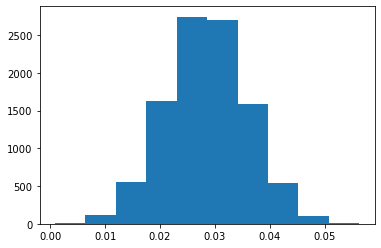

In [25]:
# convert to numpy array
diffs = np.array(diffs)

# plot distribution
plt.hist(diffs);

In [65]:
np.percentile(diffs,0.5),np.percentile(diffs,99.5)

(0.009258121627164311, 0.047037428536832016)

#### 3. Use this sampling distribution to simulate the distribution under the null hypothesis by creating a random normal distribution centered at 0 with the same spread and size.

In [26]:
# create distribution under the null hypothesis
null_vals = np.random.normal(loc = 0, scale = diffs.std(), size = diffs.size)

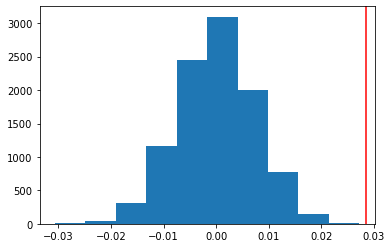

In [27]:
# plot null distribution
plt.hist(null_vals);

# plot line for observed statistic
plt.axvline(obs_diff, color = 'r');

In [28]:
# compute p value
(null_vals > obs_diff).mean()

0.0

There is evidence, with a type I error rate of 0.05, that Intellicron increases the application completion rate.

#### Statsmodels Version

In [29]:
prequals_new_after.head()

,index,prequal_id,checkout_id,prequal_date,completed_prequal,approved,assignment_date,group,checkout
0,0,00081cb5-27bb-428a-bc53-076bacc7ad02,NaN,2019-06-22,1,0,2019-06-22,experiment,0
25,25,0136e545-347d-4a3b-b964-0a4561d32567,NaN,2019-06-22,0,0,2019-06-22,experiment,0
27,27,0144b69a-f364-4746-8600-f6d7334d8f3f,NaN,2019-06-27,1,0,2019-06-27,experiment,0
43,43,01e3886c-6f22-471f-b5e5-aa85d96f048c,3e636653-cf94-40b7-b3c9-7fb118d4d2a2,2019-06-30,1,1,NaT,control,1
44,44,020412e9-c946-4252-94cf-85a4aaa75e2e,NaN,2019-06-29,0,0,2019-06-29,experiment,0


In [30]:
import statsmodels.api as sm

control = prequals_new_after.query('(group == "control") & (completed_prequal == 1)').shape[0]
experiment = prequals_new_after.query('(group == "experiment") & (completed_prequal == 1)').shape[0]
n_old = prequals_new_after.query('group == "control"').shape[0]
n_new = prequals_new_after.query('group == "experiment"').shape[0]

In [31]:
# Number of trials or observations (represented as an array for the two indepedent samples of old and new pages)
nobs = [n_old, n_new]

# Number of successes in nobs trials (number of conversions)
count = [control, experiment]

z_test , p_value = sm.stats.proportions_ztest(count, nobs, alternative ='smaller')
# value is not set because in this case, the null hypothesis is 0, so the default of 0 is accepted here

# we want a p value for values greater than the null of 0, for this function that means proportion > null/value
# the paramater would be alternative set to smaller to represent the alternative hypothesis, where the 1st proportion
# is smaller than the second proportion


z_test, p_value

(-3.8591044677105613, 5.690164271762356e-05)

In this case, z-score and p-value both represent the probability of the proportion sample statistic occuring if it originated from a normal distrubtion of the null hypothesis. A large p-value that is more than the alpha set for the significance level indicates that we cannot reject the hypothesis - or that this statistic has a high probability of being within the sampling variation of the null hypothesis. 

The z-score describes this same relationship within units of standard deviation. In this case, the sample statistic is -3.9 standard deviations from the null hypothesis of 0. A low value for the z-score also points to failing to reject the null hypothesis.

(Adding additional explanation from Udacity review for future reference) The z-score here, calculated through one tail, describes the distance from the mean after standardizing the normal distribution around 0. In addition, with a sampling distribution, a z-score of less than the z-critical value of 1.645 means that we are likely to sample such a sample from the sampling distribution given an alpha of 0.05.

## 5. Was test and control group assignment done correctly? How can you tell? Is there anything you would do differently next time?

In [35]:
prequals_new_after.head()

,index,prequal_id,checkout_id,prequal_date,completed_prequal,approved,assignment_date,group,checkout
0,0,00081cb5-27bb-428a-bc53-076bacc7ad02,NaN,2019-06-22,1,0,2019-06-22,experiment,0
25,25,0136e545-347d-4a3b-b964-0a4561d32567,NaN,2019-06-22,0,0,2019-06-22,experiment,0
27,27,0144b69a-f364-4746-8600-f6d7334d8f3f,NaN,2019-06-27,1,0,2019-06-27,experiment,0
43,43,01e3886c-6f22-471f-b5e5-aa85d96f048c,3e636653-cf94-40b7-b3c9-7fb118d4d2a2,2019-06-30,1,1,NaT,control,1
44,44,020412e9-c946-4252-94cf-85a4aaa75e2e,NaN,2019-06-29,0,0,2019-06-29,experiment,0


In [55]:
prequals_new_after.group.value_counts()/len(prequals_new_after)

control       0.531432
experiment    0.468568
Name: group, dtype: float64

In [42]:
prequals_new_after.group.value_counts()

control       9764
experiment    8609
Name: group, dtype: int64

In [62]:
# Group assignment variables
control_pct = (prequals_new_after.group.value_counts()/len(prequals_new_after))[0]
control_pct = round(control_pct*100,1)

experiment_pct = (prequals_new_after.group.value_counts()/len(prequals_new_after))[1]
experiment_pct = round(experiment_pct*100,1)

control_ct = prequals_new_after.group.value_counts()[0]
experiment_ct = prequals_new_after.group.value_counts()[1]

In [64]:
print(f"""It looks like the intent of the testing period was for 50% of the loads to ping Intellicron for SSN. 
            But the 50/50 split of control and experiment groups wasn't successful. The percent of loads for
            control and experiment was {control_pct}% and {experiment_pct}%, respectively""")

It looks like the intent of the testing period was for 50% of the loads to ping Intellicron for SSN. 
            But the 50/50 split of control and experiment groups wasn't successful. The percent of loads for
            control and experiment was 53.1% and 46.9%, respectively


## 6. Should we implement Intellicron? What other data, if any, would you need to make this determination?

In [66]:
prequals_new_after.head()

,index,prequal_id,checkout_id,prequal_date,completed_prequal,approved,assignment_date,group,checkout
0,0,00081cb5-27bb-428a-bc53-076bacc7ad02,NaN,2019-06-22,1,0,2019-06-22,experiment,0
25,25,0136e545-347d-4a3b-b964-0a4561d32567,NaN,2019-06-22,0,0,2019-06-22,experiment,0
27,27,0144b69a-f364-4746-8600-f6d7334d8f3f,NaN,2019-06-27,1,0,2019-06-27,experiment,0
43,43,01e3886c-6f22-471f-b5e5-aa85d96f048c,3e636653-cf94-40b7-b3c9-7fb118d4d2a2,2019-06-30,1,1,NaT,control,1
44,44,020412e9-c946-4252-94cf-85a4aaa75e2e,NaN,2019-06-29,0,0,2019-06-29,experiment,0


In [69]:
duration = prequals_new_after.prequal_date.max()-prequals_new_after.prequal_date.min()

In [72]:
# Calculate approved rate
control_appr = sum(prequals_new_after_control.approved)/sum(prequals_new_after_control.completed_prequal)
control_appr = round(control_appr*100,1)

experiment_appr = sum(prequals_new_after_experiment.approved)/sum(prequals_new_after_experiment.completed_prequal)
experiment_appr = round(experiment_appr*100,1)

In [77]:
print(f"""Not yet. The testing period seems too short, only lasting {duration}.

But, more importantly, there also seems to be a difference in ultimate 
approval rates between Intellicron and the classic 6-field form.

In this experiment, the approval rates for Intellicron was {experiment_appr}%,
and for the classic 6-field form, the rate was {control_appr}%. Before
implementing Intellicron it would be good to know:

    1. Is this rate difference statistically signficant?
    
    2. If the rate difference is significant, what are the causes of denials?
    
    3. What is the total cost of implementing Intellicron, and what are other 
        financial impacts of implementation? For example, a $2 charge per 
        Intellicron applicant reduces profit margin for Bread,
        but this may result in improved accuracy of credit-worthiness 
        determination for Bread merchants, improving Bread's ability to
        attract more merchants.
        """)

Not yet. The testing period seems too short, only lasting 14 days 00:00:00.

But, more importantly, there also seems to be a difference in ultimate 
approval rates between Intellicron and the classic 6-field form.

In this experiment, the approval rates for Intellicron was 64.5%,
and for the classic 6-field form, the rate was 65.8%. Before
implementing Intellicron it would be good to know:

    1. Is this rate difference statistically signficant?
    
    2. If the rate difference is significant, what are is the reason
    3. 
    . And, knowing that there is a $2 charge per application,
it should be relatively easy to calculate a rough impact to 
        
